#Setup

In [1]:
from google.colab import drive
from os.path import join
ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [9]:
%cd "/content/drive/MyDrive/study/palmistry/denoise"

/content/drive/MyDrive/study/palmistry/denoise


In [3]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(DEVICE)

cuda


#Dataset

In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from os import listdir
import logging
from os.path import splitext
from PIL import Image
import numpy as np

In [11]:
class BasicDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, size: int, mask_suffix: str = '', transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.size = size
        self.mask_suffix = mask_suffix
        self.transform = transform

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(pil_img, size, is_mask):
        newW, newH = size, size
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img_ndarray = np.asarray(pil_img)
        
        if is_mask:
            img_ndarray = np.apply_along_axis(lambda x: 1 if np.all(x == 255.) else 0, 2, img_ndarray)
            # img_ndarray.shape == (256, 256)
        else:
            img_ndarray = img_ndarray.transpose((2, 0, 1))
            # img_ndarray.shape == (3, 256, 256)
            img_ndarray = img_ndarray / 255

        return img_ndarray

    @staticmethod
    def load(filename):
        ext = splitext(filename)[1]
        if ext == '.npy':
            return Image.fromarray(np.load(filename))
        elif ext in ['.pt', '.pth']:
            return Image.fromarray(torch.load(filename).numpy())
        else:
            return Image.open(filename)

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = self.load(mask_file[0])
        img = self.load(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.size, is_mask=False)
        mask = self.preprocess(mask, self.size, is_mask=True)

        if self.transform is not None:
            transformed_imgs = self.transform(image=img, mask=mask)
            img, mask = transformed_imgs['image'], transformed_imgs['mask']

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }

class PLSUDataset(BasicDataset):
    def __init__(self, images_dir, masks_dir, size, transform=None):
        super().__init__(images_dir, masks_dir, size, mask_suffix='', transform=None)

#Data Augmentation

In [12]:
import albumentations as A
import cv2
import os
from torch.utils.data import ConcatDataset
from pathlib import Path

In [13]:
transform = A.Compose([
            A.HorizontalFlip(p=1),
            A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
            A.ColorJitter(brightness=0.6, contrast=0.6),
            A.CLAHE(p=0.5)
        ])

In [14]:
dir_img = Path('./PLSU/img')
dir_mask = Path('./PLSU/Mask')

dataset1 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset2 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset3 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset4 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)

dataset = ConcatDataset([dataset1, dataset2, dataset3, dataset4])

In [15]:
len(dataset)

4156

#Model: U-net with Context Fusion Module

In [16]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        

    def forward(self, x):
        return self.conv(x)

In [17]:
class ContextFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.context_modeling = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Softmax2d()
        )
        self.context_transform1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.context_transform2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = nn.MaxPool2d(2)(x)
        x2 = self.context_modeling(x1) * x1
        return self.context_transform1(x2) * x1 + self.context_transform2(x2)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.cfm = ContextFusion(512)
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.cfm(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Evaluate

In [19]:
def F1Score(y_pred, y_true):
    epsilon = 1e-7
    tp = (y_true * y_pred).sum()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
        
    return 2* (precision*recall) / (precision + recall + epsilon)

def IOUScore(y_pred, y_true):
    epsilon = 1e-7

    y_pred = np.where(y_pred > 0.5, 1, 0)
    intersection = (y_pred & y_true).sum()
    union = (y_pred | y_true).sum()
    iou = (intersection + epsilon) / (union + epsilon)

    return iou

In [30]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    f1_score = 0
    iou_score = 0
    # iterate over the validation set
    with tqdm(total=num_val_batches, desc='Validation round', unit='batch') as pbar:
        for batch in dataloader:
            image, mask_true = batch['image'], batch['mask']
            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                # predict the mask
                mask_pred = net(image).squeeze(1) # shape = (64, 256, 256)
                mask_pred = nn.Sigmoid()(mask_pred).detach().cpu().numpy()
                mask_true = mask_true.detach().cpu().numpy()

                f1 = F1Score(mask_pred, mask_true)
                iou = IOUScore(mask_pred, mask_true)
                
                f1_score += f1
                iou_score += iou

                pbar.update(image.shape[0])
                pbar.set_postfix(**{'F1 Score (batch)': f1, 'IOU Score (batch)': iou})

    net.train()

    return f1_score/num_val_batches, iou_score/num_val_batches

#Train

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Optimizer
from tqdm import tqdm
import torch.nn.functional as F
from pathlib import Path

In [25]:
val_percent = 0.1
test_percent = 0.1
batch_size = 64
epochs = 50

In [26]:
n_val = int(len(dataset) * val_percent)
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_val - n_test
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(0))

In [27]:
loader_args = dict(batch_size=batch_size, num_workers=2, pin_memory=True) # maximal two workers
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [28]:
net = UNet(n_channels=3, n_classes=1).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=8)
criterion = nn.BCEWithLogitsLoss()
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
global_step = 0
patience_stop = 10
patience = 0
f1_scores = []
iou_scores = []
epoch_losses = []
best_loss = 10 ** 9
dir_checkpoint = Path('./checkpoints')

In [29]:
for epoch in range(1, epochs+1):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels

                # Train round
                images = images.to(device=DEVICE, dtype=torch.float32) # shape = (64, 3, 256, 256)
                true_masks = true_masks.to(device=DEVICE, dtype=torch.float32) # shape = (64, 256, 256)

                with torch.cuda.amp.autocast(enabled=True):
                    masks_pred = net(images).squeeze(1) # shape = (64, 256, 256)
                    loss = criterion(masks_pred, true_masks)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                pbar.set_postfix(**{'loss (batch)': loss.item()})

        # an epoch finished
        epoch_losses.append(epoch_loss)

        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(net.state_dict(), str(dir_checkpoint / '/checkpoint_epoch{}.pth'.format(epoch)))
        logging.info(f'Checkpoint {epoch} saved!')

        # schedule learning rate
        scheduler.step(epoch_loss)
        f1, iou = evaluate(net, val_loader, DEVICE)
        f1_scores.append(f1)
        iou_scores.append(iou)

        # early stop
        if epoch_loss > best_loss:
            patience += 1
            if patience_stop == patience:
                print(f"early stopped in epoch={epoch}")
                break
            else:
                best_loss = epoch_loss
                patience = 0

Validation round:   0%|          | 0/6 [01:22<?, ?batch/s]


TypeError: ignored

#Test

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

In [ ]:
for data in test_loader:
    img = data['image']
    mask = data['mask']
    with torch.no_grad():
        img = img.to(device=DEVICE, dtype=torch.float32)
        mask = mask.to(device=DEVICE, dtype=torch.float32)
        output = net(img)
        print(output.shape)
        # output = torch.Tensor(np.apply_along_axis(lambda x: [1,1,1] if x[0] > x[1] else [0,0,0], 1, output.cpu().detach()))
        # plt.imshow(make_grid(output.squeeze().permute((1,2,0))))
        # plt.show()

torch.Size([2, 256, 256])
(256, 256)
(256, 256)
0.0
(256, 256, 3)


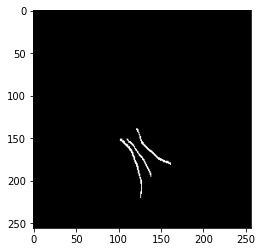

torch.Size([2, 256, 256])
(256, 256)
(256, 256)
0.0
(256, 256, 3)


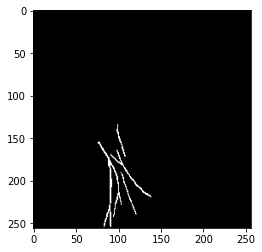

torch.Size([2, 256, 256])
(256, 256)
(256, 256)
0.0
(256, 256, 3)


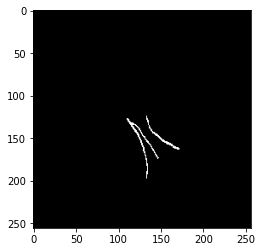

KeyboardInterrupt: ignored

In [ ]:
for batch in dataset:
    print(batch['mask'].shape)
    true = np.apply_along_axis(lambda x: 1 if x[0] < x[1] else 0, 0, batch['mask'])
    print(true.shape)
    pred = net(batch['image'].unsqueeze(0).cuda())[0].permute(1,2,0)
    
    pred = np.apply_along_axis(lambda x: 1 if x[0] < x[1] else 0, 2, pred.detach().cpu().numpy())
    print(pred.shape)
    # print(F1Score(pred, true))
    
    # print(pred.detach().numpy().shape, batch['mask'].numpy().shape)
    print(IOUScore(pred, true))
    mask = np.apply_along_axis(lambda x: [255, 255, 255] if x[1] == 1 else [0, 0, 0], 0, batch['mask']).transpose((1,2,0))
    print(mask.shape)
    plt.imshow(mask)
    plt.show()

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
print(input, m(input))
target = torch.empty(3).random_(2)
print(target)
output = loss(m(input), target)
print(output)
output.backward()

tensor([-0.3508,  0.1900, -1.1296], requires_grad=True) tensor([0.4132, 0.5474, 0.2442], grad_fn=<SigmoidBackward0>)
tensor([1., 0., 0.])
tensor(0.6522, grad_fn=<BinaryCrossEntropyBackward0>)
